In [1]:
import cv2
import matplotlib.pyplot as plt
from copy import copy
import pandas as pd
import os
from sklearn.manifold import TSNE
import numpy as np

from sklearn.decomposition import PCA



## В данном случае хочется попробовать использовать алгоритм TSNE для визуализации 'цвета' кадров в двумерном пространстве (как это сделано в статье про Уэса Андерсона). Вообще статья очень удобная для нас в случае, если мы хотим увидеть одинаковые паттерны у разных режиссеров (одинаковое изображение сна, например, или скачек, или еще чего-нибудь). Может быть, у нас этого и не получится, но вдруг. 

In [14]:
def extract_every_k_second_frame(path_to_video, k: int, num_frames_per_sec=24):
    '''Функция отвечает за вычленение первого кадра каждой n-ной секунды (кадров т.о. становится меньше, 
    k - это номер секунды).
    Проблема: есть все-таки монтажные черные склейки, и n-ные секунды могут выпадать на них, из-за чего кадры
    могут получаться не очень качественными. Возможно, этого не будет заметно, или же количество черных кадров
    будет минимальным'''
    
    vidcap = cv2.VideoCapture(path_to_video)
    success,image = vidcap.read()
    count = 0
    while success:
        success,image = vidcap.read()
    #     print('Read a new frame: ', success, ' ', count) #это вероятно можно убрать
        count += 1
        if count % (num_frames_per_sec * k) == 0:
            cv2.imwrite("10_frames/{}_frame.jpg".format(count // num_frames_per_sec * k), image[88:630, 0:])     

In [15]:
extract_every_k_second_frame('Anna_Karenina_Official_Trailer.mp4', 1)

In [16]:
def img_into_pixels(path_to_img):
    '''В этой функции мы каждый пиксель разделяем на три канала - RGB'''
    img = cv2.imread(path_to_img)

#convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#get rgb values from image to 1D array
    r, g, b = cv2.split(img)
    r = r.flatten()
    g = g.flatten()
    b = b.flatten()
    
    return r, g, b

In [31]:
directory = '10_frames'
data = []
src = []
for file in os.listdir(directory):
    if file.endswith('.jpg'):
        src.append(os.path.join(directory, file))
        pixels = img_into_pixels(os.path.join(directory, file))
        data.append(np.array(pixels).flatten()) #делаем список из слитых матриц rgb для каждой картинки -
                                                #в итоге у нас один длинный вектор на каждую картинку
data = np.array(data)
src = ["10_frames/{}_frame.jpg".format(i) for i in range(1, len(src) + 1)] #это пути к нашим картинкам

In [32]:
data

array([[ 96,  96,  96, ...,  78,  78,  78],
       [ 90,  90,  90, ...,  28,  28,  28],
       [  1,   1,   1, ...,   3,   3,   3],
       ...,
       [ 92,  94,  95, ...,   0,   1,   5],
       [ 11,  11,  11, ..., 199, 199, 199],
       [ 10,  10,  11, ...,  48,  48,  48]], dtype=uint8)

In [18]:
'''Здесь я как бы схлопываю свою матрицу, у которой была размерность 150 х 2764800 до 150 х 50'''
pca = PCA(50)
pca_data = pca.fit_transform(data)

150

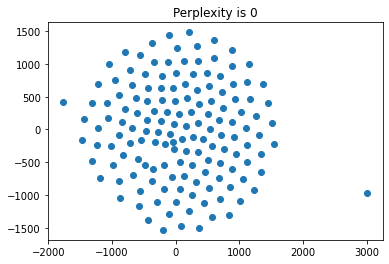

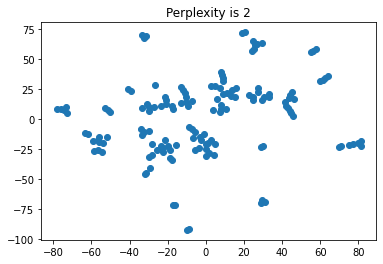

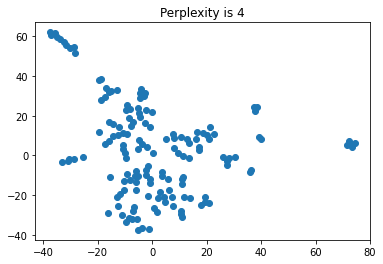

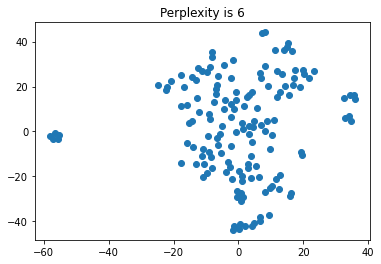

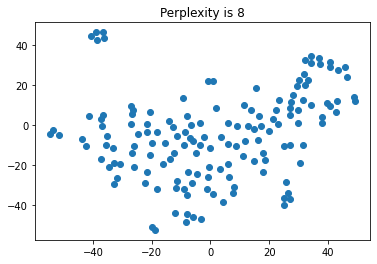

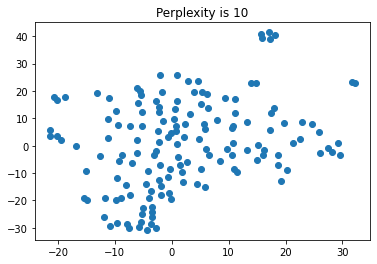

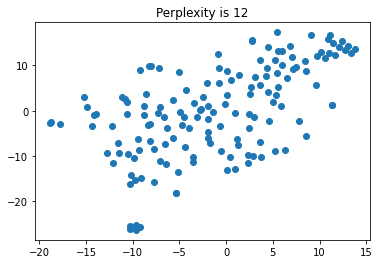

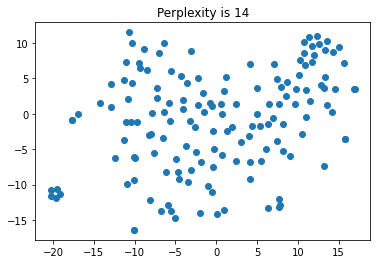

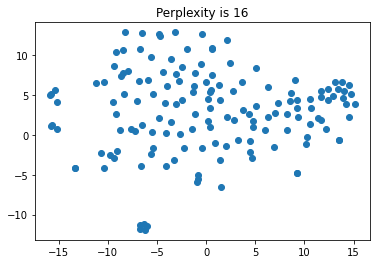

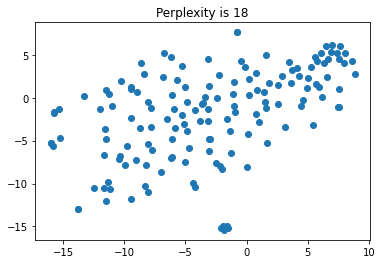

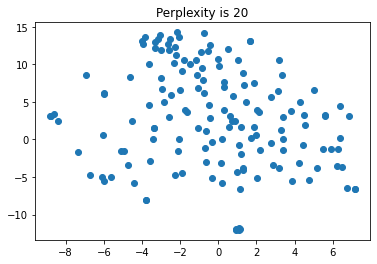

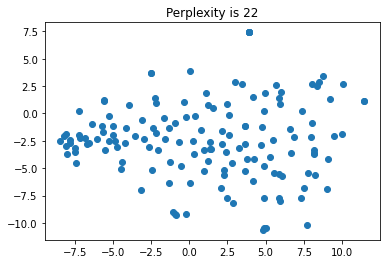

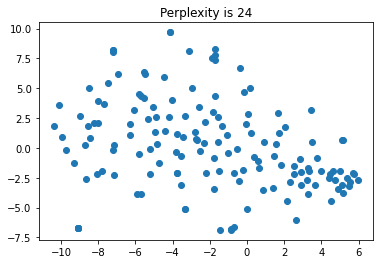

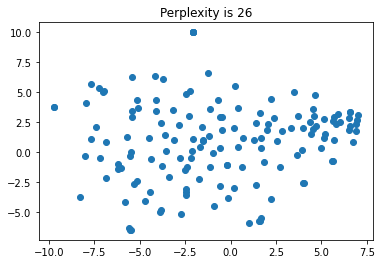

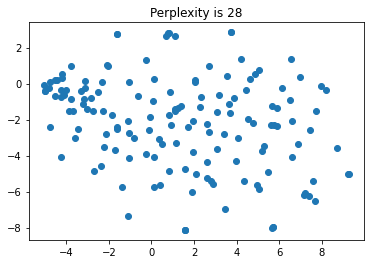

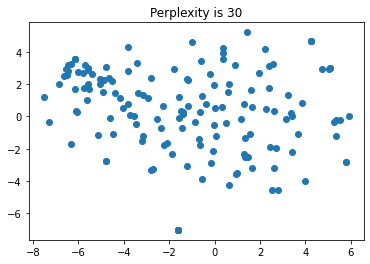

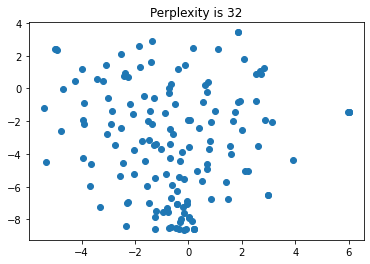

In [35]:
'''perplexity - атрибут TSNE. 
Вот что про него написано:
perplexityfloat, optional (default: 30)
The perplexity is related to the number of nearest neighbors that is used 
in other manifold learning algorithms. Larger datasets usually require a 
larger perplexity. Consider selecting a value between 5 and 50. 
Different values can result in significanlty different results.

Этот атрибут надо подбирать в зависимости от того, какие у нас данные'''

perplexity_r = range(0, 33, 2)
for perplexity in perplexity_r:
    tsne = TSNE(2, perplexity=perplexity)
    tsne_data = tsne.fit_transform(pca_data)#fit загружает в алгоритм данные и обучает алгоритм сжатия данных
                                            #а transform преобразует из многомерной матрицы в матрицу нужного размера
    
    plt.scatter(tsne_data[:,0], tsne_data[:, 1])
    plt.title("Perplexity is {}".format(perplexity))
    plt.show()

###### Для красного цвета

In [8]:
data_r = data[:, :data.shape[1] // 3]
pca = PCA(50)
pca_data_r = pca.fit_transform(data_r)

KeyboardInterrupt: 

In [270]:
tsne = TSNE(2, perplexity=5)
tsne_data_r = tsne.fit_transform(pca_data_r)

#### Вот тут - пример того, как сделать так, чтобы картинки отображались. 
https://docs.bokeh.org/en/latest/docs/user_guide/tools.html#custom-tooltip

In [38]:
'''Код визуализации, на которой можно отобразить изображения при наведении мышки на точку.'''
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
from bokeh.plotting import ColumnDataSource, figure, output_file, show
output_notebook()

# output_file("toolbar.html")

tsne = TSNE(2, perplexity=4)
tsne_data = tsne.fit_transform(pca_data)


source = ColumnDataSource(data=dict(
    x= tsne_data[:,0],
    y= tsne_data[:, 1],
    desc=list(range(len(src))),
    imgs= src,
    fonts = ['<i>trailer</i>'] * len(src)
))

TOOLTIPS = """
    <div>
        <div>
            <img
                src="@imgs" height="187" alt="@imgs" width=333""
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
        <div>
            <span style="font-size: 17px; font-weight: bold;">@desc</span>
            <span style="font-size: 15px; color: #966; alpha: 0.25">[$index]</span>
        </div>
        <div>
            <span>@fonts{safe}</span>
        </div>
        <div>
            <span style="font-size: 15px;">Location</span>
            <span style="font-size: 10px; color: #696;  alpha: 0.25">($x, $y)</span>
        </div>
    </div>
"""

p = figure(plot_width=1000, plot_height=600, tooltips=TOOLTIPS,
           title="Anna Karenina 2012")

p.circle('x', 'y', size=15, alpha=0.50, color='#62b696', source=source)

show(p)

Loading BokehJS ...

In [ ]:
data